In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

FileNotFoundError: [Errno 2] No such file or directory: '../input'

# Baseline RF model: Reproducing the 2017 Rouet-Leduc et al. paper

_ONGOING WORK, FEATURE ENGINEERING STILL INCOMPLETE_

We read: "_The competition builds on initial work from Bertrand Rouet-Leduc, Claudia Hulbert, and Paul Johnson. B. Rouet-Leduc prepared the data for the competition._" Their original article is:

Rouet-leduc, B., Hulbert, C., Lubbers, N., Barros, K., Humphreys, C.J., Johnson, P.A. (2017), Machine Learning Predicts Laboratory Earthquakes. Geophys. Res. Lett., 44, 9276-9282, doi: [10.1002/2017GL074677](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL074677)

In the introduction of the competition's discussion section, Bertrand Rouet-Leduc gives us more details and links to three additional articles. Compared to what has been published, he mentions that, for this Kaggle competition, they selected "_an experiment that exhibits a **very aperiodic** and more realistic behavior compared to the data we studied in our early work, with **earthquakes occurring very irregularly**._" He adds on a second post that "_you will have to build a model that predicts the time remaining before failure from a chunk of seismic data, like we have done in our first paper above on easier data._"

After a quick search on the discussion and kernel list, I could not find any obvious link to a work trying to reproduce the 2017 Rouet-Leduc article. I will therefore summarize their work below and try to apply their method to the LANL Kaggle dataset. It is very likely that others already did it (please comment if so) but I will here focus on this 2017 study and describe it in detail, which I believe might be of interest to some Kagglers.



## I. The Rouet-Leduc et al. (2017) study

### 1. Abstract

I here simply copy-paste their abstract from the GRL website:

"_We apply machine learning to data sets from shear laboratory experiments, with the goal of identifying hidden signals that precede earthquakes. Here we show that by listening to the acoustic signal emitted by a laboratory fault, machine learning can predict the time remaining before it fails with great accuracy. These predictions are based solely on the instantaneous physical characteristics of the acoustical signal and do not make use of its history. Surprisingly, machine learning identifies a signal emitted from the fault zone previously thought to be low-amplitude noise that enables failure forecasting throughout the laboratory quake cycle. We infer that this signal originates from continuous grain motions of the fault gouge as the fault blocks displace. We posit that applying this approach to continuous seismic data may lead to significant advances in identifying currently unknown signals, in providing new insights into fault physics, and in placing bounds on fault failure times._"


### 2. Method

Rouet-Leduc et al. (2017) applied the **Random Forest algorithm** to the continuous acoustic time series data. For each time window, the authors computed a set of **c. 100 potentially relevant statistical features (incl. mean, variance, kurtosis & autocorrelation)**. Then, they used **recursive feature elimination** for feature reduction.

#### a. Random Forest

To apply a Random Forest, we will need to define several hyperparameters:

In [2]:
from sklearn.ensemble import RandomForestRegressor

#model_RF = RandomForestRegressor(n_estimators = n_estimators,     # number of trees in the forest
#                                 criterion = criterion,           # quality of split measure
#                                 max_depth = max_depth,
#                                 max_features = max_features)     # nb. of features to consider for best split

We learn from their Fig. 1 that "_the RF model predicts the time remaining before the next failure by averaging the predictions of 1,000 decision trees for each time window._" which gives us **n_estimators = 1000**. In Fig. 2, we learn that the RF was trained of c. 150 s of data (c. 10 slip events) and tested on the following c. 150 s.

No more details are given in the main text and we have to turn to the supplementary material to get more details about the engineered features and hyperparameters:

At each node, they selected a random subset of 40% of the available features, which gives us **max_features = 0.4**. We learn later on that this value had been selected via 3-fold cross-validation (from a range 30-40%).

As split criterion, they used maximum reduction of empirical variance, which is **criterion = 'mse'** (the default in RandomForestRegressor). No information was given about maximum depth.

#### b. Feature engineering

The authors used moving time windows of 1.8 s each, with an offset of 0.18 s (i.e. 90% overlap between consecutive windows). Each window corresponds to one observation X_i (feature vector) and label y_i (time remaining until next failure).

Here is the list of features:
- Signal distribution (to capture evolution of signal's energy) = 7 features: **kth-order moment** of acoustic data corresponding to mean, normalized/non-normalized variance, skewness, kurtosis;
- Precursors (bursts of acoustic emissions) = 18+10+2 = 30 features: **1st-to-9th and 91th-to-99th percentiles** (per 1% increment), the fraction of times the strain is greater than **thresholds f_0 derived from signal processing** with **f_0 = 1e-9, 5e-9, 1e-8, 5.e-8 and 1e-7** and the fraction of times it is lower than their negatives -f_0, and finally **min/max** values;
- Time correlation = 5 features: **Fourier transforms** on frequency bands {(19.65, 20.65), (39.8, 40.8), (80.1, 81.1)} in kHz, the **autocorrelation** and the **partial autocorrelation**.

Features were originally defined from the raw data and the **first finite difference of the data**. The authors found that the RF had a **slight performance advantage when only using the derivative signal**.

We verify that we get (7+30+5) times 2 = **84 features**. The doubling comes from a **window split**, which gave the algorithm a notion of **short-term evolution of the signal**. It means that the 42 features were estimated twice for the two subwindows of each "observation". We will describe in detail these different features in part II.


### 3. Results

Rouet-Leduc et al. (2017) obtained R^2 = 0.89 for the RF model compared to R^2 = 0.3 for a naive model based on event periodicity, which means that the RF model explains 89% of the data variance. No mean absolute error (MAE) was given in the paper, which hampers direct comparison with the Kaggle competition leaderboard.

<br><br>



## II. Comparison with the LAN Kaggle competition

Comparison of their experiment with the Kaggle LAN competition. I once again took some inspiration from Grand Kernel Master [Andrew Lukyanenko](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples) for EDA.

### 1. LANL EDA

The training data set is c. 10 GB

In [3]:
pd.options.display.precision = 15
import scipy
import matplotlib.pyplot as plt

#### a. Training set

In [4]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 20s, sys: 15.1 s, total: 2min 35s
Wall time: 2min 36s


In [5]:
train.shape

(629145480, 2)

In [6]:
train.dtypes

acoustic_data        int16
time_to_failure    float32
dtype: object

In [7]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [8]:
train.tail()

,acoustic_data,time_to_failure
629145475,7,9.759795188903809
629145476,9,9.759795188903809
629145477,10,9.759795188903809
629145478,6,9.759795188903809
629145479,5,9.759795188903809


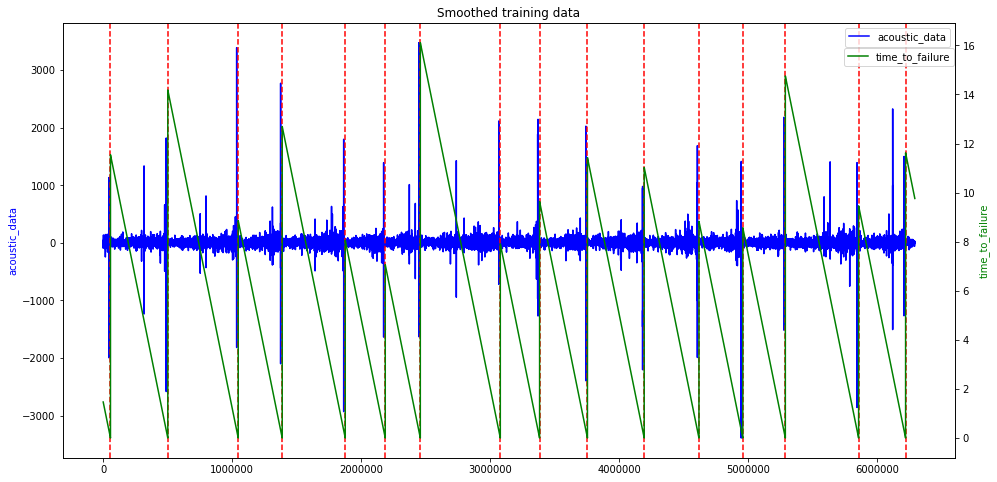

In [9]:
train_acoustic_data_small = train['acoustic_data'].values[::100]      #skip 100 rows
train_time_to_failure_small = train['time_to_failure'].values[::100]

tf = train.loc[np.diff(train['time_to_failure']) > 0].index.values

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Smoothed training data')
plt.plot(train_acoustic_data_small, color = 'b')
for ti in tf:
    plt.axvline(x = ti/100, color = 'r', linestyle = '--')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

#del train_acoustic_data_small
#del train_time_to_failure_small

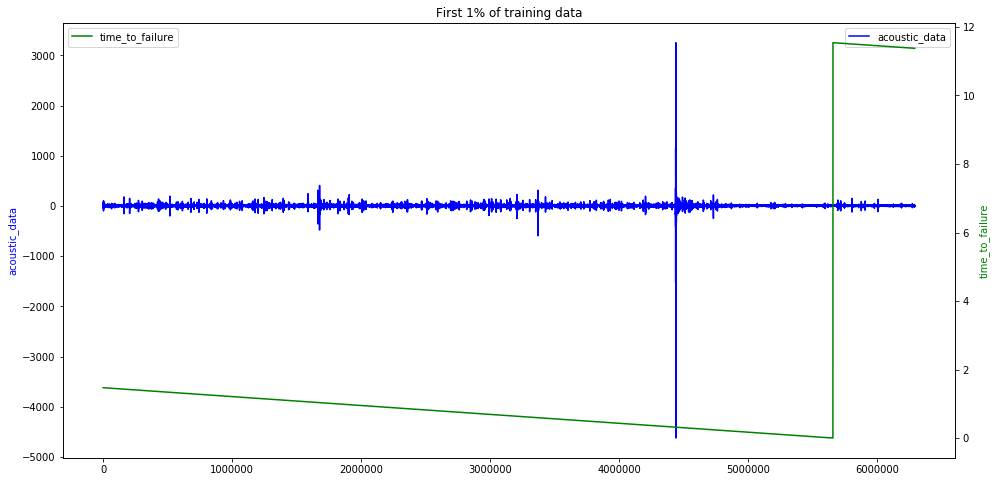

In [10]:
p = 0.01   # first p percentage of training data
indp = round(629145480*p)

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('First 1% of training data')
plt.plot(train['acoustic_data'].values[:indp], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:indp], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'])

#### b. Test set

In [11]:
submission = pd.read_csv('../input/sample_submission.csv')
seg_id = submission['seg_id']
n_test = len(seg_id)
n_test

2624

In [12]:
test0 = pd.read_csv('../input/test/' + seg_id[0] + '.csv')
np.shape(test0)

(150000, 1)

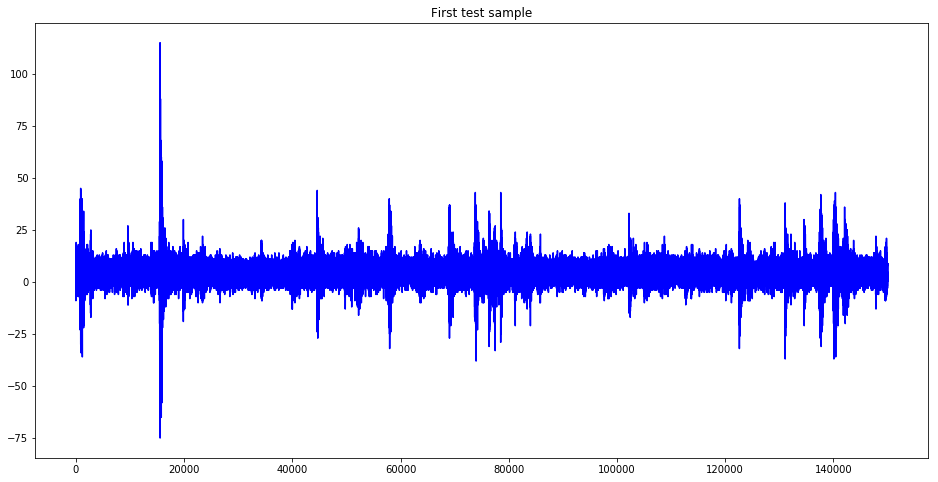

In [13]:
plt.subplots(figsize=(16, 8))
plt.title('First test sample')
plt.plot(test0['acoustic_data'], color='b')

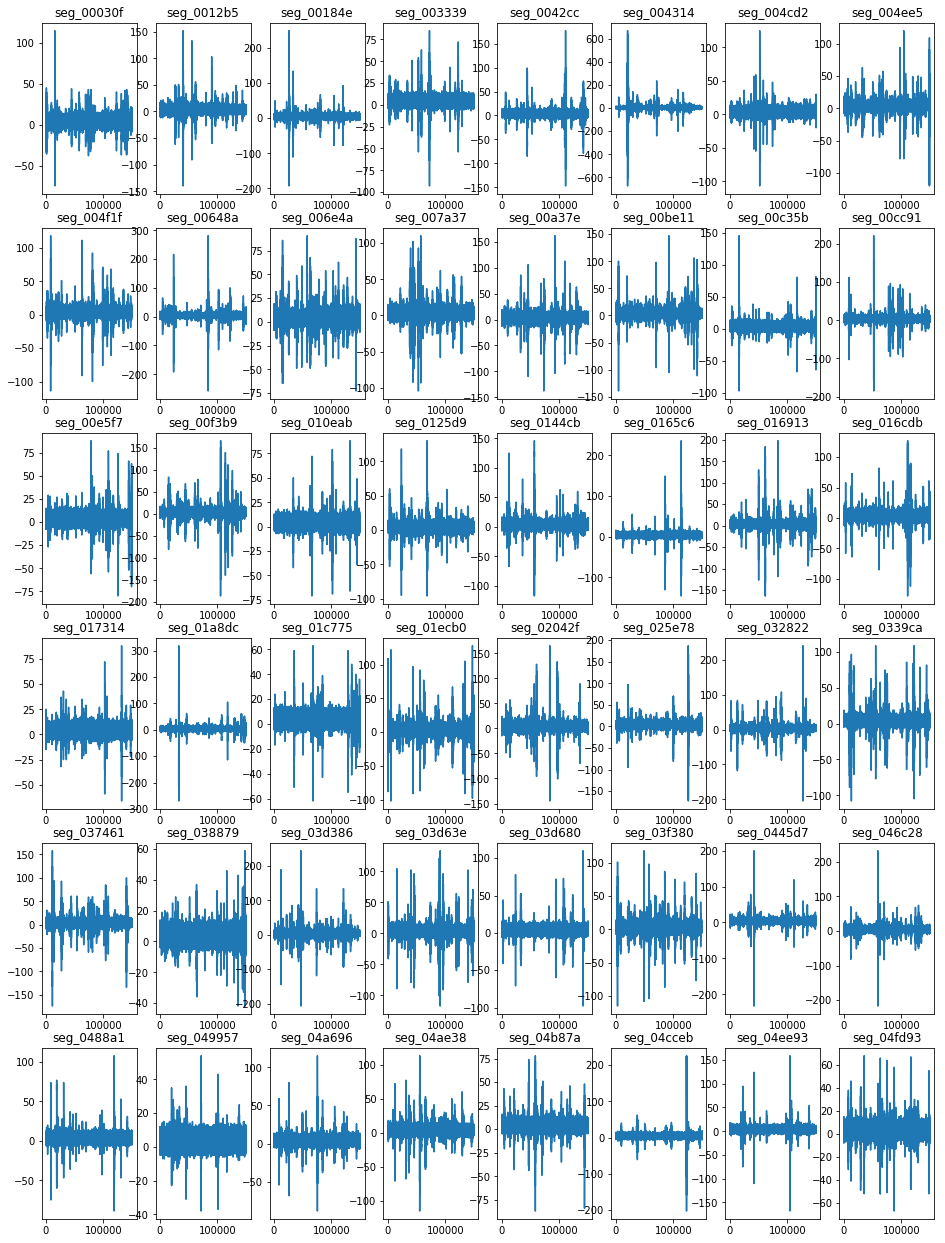

In [14]:
plt.subplots(figsize=(16, 22))
for i in range(48):
    testi = pd.read_csv('../input/test/' + seg_id[i] + '.csv')
    plt.subplot(6, 8, i + 1)
    plt.plot(testi['acoustic_data'])
    plt.title(seg_id[i])

### 2. Feature engineering

Rouet-Leduc et al. (2017) sampled their data into time windows of 1.8 s each with an offset of 0.18 s. However we have no information about time binning in the test data. Moreover the time bin in the training set is irregular. Therefore we cannot reproduce the same sampling. The simplest option is therefore to sample the training set in samples of 150,000 successive records to match the test set samples.

In [15]:
records = 150000
n_train = int(np.floor(train.shape[0] / records))
n_train

4194

This seems reasonable, with c. 60% of observations in training set and 40% in test set. Let's now define the same features as in the 2017 study.

#### Define features for training set

In [16]:
f0pos = (1e-9, 5e-9, 1e-8, 5e-8, 1e-7)
f0neg = (-1e-9, -5e-9, -1e-8, -5e-8, -1e-7)

X_train = pd.DataFrame(index = range(n_train), columns = 
                    ['meanA', 'varA', 'varAnorm', 'skewA', 'skewAnorm', 'kurtA', 'kurtAnorm',
                     'meanB', 'varB', 'varBnorm', 'skewB', 'skewBnorm', 'kurtB', 'kurtBnorm',
                     'q01A', 'q02A', 'q03A', 'q04A', 'q05A', 'q06A', 'q07A', 'q08A', 'q09A',
                     'q01B', 'q02B', 'q03B', 'q04B', 'q05B', 'q06B', 'q07B', 'q08B', 'q09B',
                     'q91A', 'q92A', 'q93A', 'q94A', 'q95A', 'q96A', 'q97A', 'q98A', 'q99A',
                     'q91B', 'q92B', 'q93B', 'q94B', 'q95B', 'q96B', 'q97B', 'q98B', 'q99B',
                     'f00pA', 'f01pA', 'f02pA', 'f03pA', 'f04pA', 'f00nA', 'f01nA', 'f02nA', 'f03nA', 'f04nA',
                     'f00pB', 'f01pB', 'f02pB', 'f03pB', 'f04pB', 'f00nB', 'f01nB', 'f02nB', 'f03nB', 'f04nB',
                     'minA', 'maxA', 'minB', 'maxB'
                    ])

y_train = pd.DataFrame(index = range(n_train), columns = ['time_to_failure'])

Not sure how the higher moments should be normalized. At the present time, the time-correlation set of features from Rouet-Leduc et al. (2017) are not included since the authors mentioned that they "_only very marginally improve the predictions._" Also, I only use the raw data for now since the authors obtained only slightly better results with the first finite difference of the data.

In [17]:
for i in range(n_train):
    if i % 100 == 0:
        print(i)
    
    segment = train.iloc[i*records : i*records + records]
    y_train.loc[i, 'time_to_failure'] = segment['time_to_failure'].values[-1]

    X_train.loc[i, 'meanA'] = segment['acoustic_data'][0:round(records/2)].mean()
    X_train.loc[i, 'meanB'] = segment['acoustic_data'][round(records/2)+1:records].mean()
    X_train.loc[i, 'varA'] = segment['acoustic_data'][0:round(records/2)].var()
    X_train.loc[i, 'varB'] = segment['acoustic_data'][round(records/2)+1:records].var()
    X_train.loc[i, 'skewA'] = scipy.stats.skew(segment['acoustic_data'][0:round(records/2)])
    X_train.loc[i, 'skewB'] = scipy.stats.skew(segment['acoustic_data'][round(records/2)+1:records])
    X_train.loc[i, 'kurtA'] = scipy.stats.kurtosis(segment['acoustic_data'][0:round(records/2)])
    X_train.loc[i, 'kurtB'] = scipy.stats.kurtosis(segment['acoustic_data'][round(records/2)+1:records])
    X_train.loc[i, 'varAnorm'] = X_train.loc[i, 'varA']/(X_train.loc[i, 'varA']+X_train.loc[i, 'varB'])
    X_train.loc[i, 'varBnorm'] = X_train.loc[i, 'varB']/(X_train.loc[i, 'varA']+X_train.loc[i, 'varB'])
    X_train.loc[i, 'skewAnorm'] = X_train.loc[i, 'skewA']/(X_train.loc[i, 'skewA']+X_train.loc[i, 'skewB'])
    X_train.loc[i, 'skewBnorm'] = X_train.loc[i, 'skewB']/(X_train.loc[i, 'skewA']+X_train.loc[i, 'skewB'])
    X_train.loc[i, 'kurtAnorm'] = X_train.loc[i, 'kurtA']/(X_train.loc[i, 'kurtA']+X_train.loc[i, 'kurtB'])
    X_train.loc[i, 'kurtBnorm'] = X_train.loc[i, 'kurtB']/(X_train.loc[i, 'kurtA']+X_train.loc[i, 'kurtB'])
    
    X_train.loc[i, 'q01A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.01)
    X_train.loc[i, 'q02A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.02)
    X_train.loc[i, 'q03A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.03)
    X_train.loc[i, 'q04A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.04)
    X_train.loc[i, 'q05A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.05)
    X_train.loc[i, 'q06A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.06)
    X_train.loc[i, 'q07A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.07)
    X_train.loc[i, 'q08A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.08)
    X_train.loc[i, 'q09A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.09)
    X_train.loc[i, 'q91A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.91)
    X_train.loc[i, 'q92A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.92)
    X_train.loc[i, 'q93A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.93)
    X_train.loc[i, 'q94A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.94)
    X_train.loc[i, 'q95A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.95)
    X_train.loc[i, 'q96A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.96)
    X_train.loc[i, 'q97A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.97)
    X_train.loc[i, 'q98A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.98)
    X_train.loc[i, 'q99A'] = np.quantile(segment['acoustic_data'][0:round(records/2)], 0.99)
    X_train.loc[i, 'q01B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.01)
    X_train.loc[i, 'q02B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.02)
    X_train.loc[i, 'q03B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.03)
    X_train.loc[i, 'q04B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.04)
    X_train.loc[i, 'q05B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.05)
    X_train.loc[i, 'q06B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.06)
    X_train.loc[i, 'q07B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.07)
    X_train.loc[i, 'q08B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.08)
    X_train.loc[i, 'q09B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.09)
    X_train.loc[i, 'q91B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.91)
    X_train.loc[i, 'q92B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.92)
    X_train.loc[i, 'q93B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.93)
    X_train.loc[i, 'q94B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.94)
    X_train.loc[i, 'q95B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.95)
    X_train.loc[i, 'q96B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.96)
    X_train.loc[i, 'q97B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.97)
    X_train.loc[i, 'q98B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.98)
    X_train.loc[i, 'q99B'] = np.quantile(segment['acoustic_data'][round(records/2)+1:records], 0.99)

    X_train.loc[i, 'f00pA'] = sum(segment['acoustic_data'][0:round(records/2)] >= f0pos[0])/75000
    X_train.loc[i, 'f01pA'] = sum(segment['acoustic_data'][0:round(records/2)] >= f0pos[1])/75000
    X_train.loc[i, 'f02pA'] = sum(segment['acoustic_data'][0:round(records/2)] >= f0pos[2])/75000
    X_train.loc[i, 'f03pA'] = sum(segment['acoustic_data'][0:round(records/2)] >= f0pos[3])/75000
    X_train.loc[i, 'f04pA'] = sum(segment['acoustic_data'][0:round(records/2)] >= f0pos[4])/75000
    X_train.loc[i, 'f00nA'] = sum(segment['acoustic_data'][0:round(records/2)] <= f0neg[0])/75000
    X_train.loc[i, 'f01nA'] = sum(segment['acoustic_data'][0:round(records/2)] <= f0neg[1])/75000
    X_train.loc[i, 'f02nA'] = sum(segment['acoustic_data'][0:round(records/2)] <= f0neg[2])/75000
    X_train.loc[i, 'f03nA'] = sum(segment['acoustic_data'][0:round(records/2)] <= f0neg[3])/75000
    X_train.loc[i, 'f04nA'] = sum(segment['acoustic_data'][0:round(records/2)] <= f0neg[4])/75000
    X_train.loc[i, 'f00pB'] = sum(segment['acoustic_data'][round(records/2)+1:records] >= f0pos[0])/74999
    X_train.loc[i, 'f01pB'] = sum(segment['acoustic_data'][round(records/2)+1:records] >= f0pos[1])/74999
    X_train.loc[i, 'f02pB'] = sum(segment['acoustic_data'][round(records/2)+1:records] >= f0pos[2])/74999
    X_train.loc[i, 'f03pB'] = sum(segment['acoustic_data'][round(records/2)+1:records] >= f0pos[3])/74999
    X_train.loc[i, 'f04pB'] = sum(segment['acoustic_data'][round(records/2)+1:records] >= f0pos[4])/74999
    X_train.loc[i, 'f00nB'] = sum(segment['acoustic_data'][round(records/2)+1:records] <= f0neg[0])/74999
    X_train.loc[i, 'f01nB'] = sum(segment['acoustic_data'][round(records/2)+1:records] <= f0neg[1])/74999
    X_train.loc[i, 'f02nB'] = sum(segment['acoustic_data'][round(records/2)+1:records] <= f0neg[2])/74999
    X_train.loc[i, 'f03nB'] = sum(segment['acoustic_data'][round(records/2)+1:records] <= f0neg[3])/74999
    X_train.loc[i, 'f04nB'] = sum(segment['acoustic_data'][round(records/2)+1:records] <= f0neg[4])/74999
    
    X_train.loc[i, 'minA'] = min(segment['acoustic_data'][0:round(records/2)])
    X_train.loc[i, 'maxA'] = max(segment['acoustic_data'][0:round(records/2)])
    X_train.loc[i, 'minB'] = min(segment['acoustic_data'][round(records/2)+1:records])
    X_train.loc[i, 'maxB'] = max(segment['acoustic_data'][round(records/2)+1:records])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [18]:
X_train.head()

,meanA,varA,varAnorm,skewA,skewAnorm,kurtA,kurtAnorm,meanB,varB,varBnorm,skewB,skewBnorm,kurtB,kurtBnorm,q01A,q02A,q03A,q04A,q05A,q06A,q07A,q08A,q09A,q01B,q02B,q03B,q04B,q05B,q06B,q07B,q08B,q09B,q91A,q92A,q93A,q94A,q95A,q96A,q97A,q98A,q99A,q91B,q92B,q93B,q94B,q95B,q96B,q97B,q98B,q99B,f00pA,f01pA,f02pA,f03pA,f04pA,f00nA,f01nA,f02nA,f03nA,f04nA,f00pB,f01pB,f02pB,f03pB,f04pB,f00nB,f01nB,f02nB,f03nB,f04nB,minA,maxA,minB,maxB
0,4.97209333333333,35.9224068500469,0.690449269182217,-0.0804029887630466,-10.4475030739765,33.1870057413075,0.797987034087085,4.79610394805264,16.1051764256863,0.309550730817783,0.0880988935350989,11.4475030739765,8.40139648038294,0.202012965912915,-11,-6,-4,-3,-2,-2,-1,-1,0,-5,-3,-2,-2,-1,-1,0,0,0,10,11,11,12,12,13,14,17,21,9,10,10,10,11,11,12,13,15,0.87328,0.87328,0.87328,0.87328,0.87328,0.0890133333333333,0.0890133333333333,0.0890133333333333,0.0890133333333333,0.0890133333333333,0.89590527873705,0.89590527873705,0.89590527873705,0.89590527873705,0.89590527873705,0.0652542033893785,0.0652542033893785,0.0652542033893785,0.0652542033893785,0.0652542033893785,-98,104,-37,52
1,4.69746666666667,60.1119417414454,0.69233823316507,0.533107570884091,1.43171918946259,92.4976758388192,0.644754684952135,4.75406338751183,26.7125883247907,0.30766176683493,-0.160752730069114,-0.43171918946259,50.9641368437609,0.355245315047865,-13,-8,-5,-4,-3,-2,-2,-1,-1,-9,-5,-3,-2,-2,-1,-1,0,0,10,11,11,12,12,13,15,17,23,10,10,10,11,11,12,13,14,18,0.85772,0.85772,0.85772,0.85772,0.85772,0.10132,0.10132,0.10132,0.10132,0.10132,0.886038480513074,0.886038480513074,0.886038480513074,0.886038480513074,0.886038480513074,0.0768810250803344,0.0768810250803344,0.0768810250803344,0.0768810250803344,0.0768810250803344,-154,181,-115,111
2,4.75193333333333,38.6114710818366,0.397880448838902,-0.0748639263141342,-0.273203441067486,23.7564125720953,0.3992701202482,5.06088081174416,58.4314250808498,0.602119551161098,0.348886559490418,1.27320344106749,35.7431877419164,0.6007298797518,-14,-8,-5,-4,-3,-2,-2,-1,-1,-18,-10,-6,-4,-3,-2,-2,-1,-1,10,11,11,12,12,13,15,17,23,11,11,12,12,13,14,16,20,28,0.864,0.864,0.864,0.864,0.864,0.0961733333333333,0.0961733333333333,0.0961733333333333,0.0961733333333333,0.0961733333333333,0.870971612954839,0.870971612954839,0.870971612954839,0.870971612954839,0.870971612954839,0.0938412512166829,0.0938412512166829,0.0938412512166829,0.0938412512166829,0.0938412512166829,-87,97,-106,140
3,4.8266,69.9066911958826,0.729516148303059,0.908867950345338,1.18655445708235,104.264362374947,0.753242909344443,4.97785303804051,25.9194140363234,0.270483851696941,-0.142895562883092,-0.186554457082351,34.1562733608604,0.246757090655557,-16,-9,-6,-4,-3,-2,-2,-1,-1,-8,-4,-3,-2,-1,-1,0,0,0,10,11,11,12,13,14,15,18,26,10,10,10,11,11,12,13,14,18,0.863373333333333,0.863373333333333,0.863373333333333,0.863373333333333,0.863373333333333,0.09832,0.09832,0.09832,0.09832,0.09832,0.894571927625702,0.894571927625702,0.894571927625702,0.894571927625702,0.894571927625702,0.0698009306790757,0.0698009306790757,0.0698009306790757,0.0698009306790757,0.0698009306790757,-199,197,-79,84
4,4.9078,27.8788442112562,0.261493626338059,-0.163368420596734,2.85265454129089,32.8953099136981,0.428815092099251,4.9097054627395,78.7350132722696,0.738506373661941,0.106099509050646,-1.85265454129089,43.8167986845794,0.571184907900749,-9,-5,-3,-2,-2,-1,-1,0,0,-22,-11,-7,-4,-3,-2,-2,-1,-1,10,10,11,11,11,12,13,15,19,11,11,11,12,13,14,17,22,33,0.888053333333333,0.888053333333333,0.888053333333333,0.888053333333333,0.888053333333333,0.0750933333333333,0.0750933333333333,0.0750933333333333,0.0750933333333333,0.0750933333333333,0.868424912332164,0.868424912332164,0.868424912332164,0.868424912332164,0.868424912332164,0.0958679449059321,0.0958679449059321,0.0958679449059321,0.0958679449059321,0.0958679449059321,-96,93,-126,145


Let us produce a figure similar to Fig. 1b of Rouet-Leduc et al. (2017):

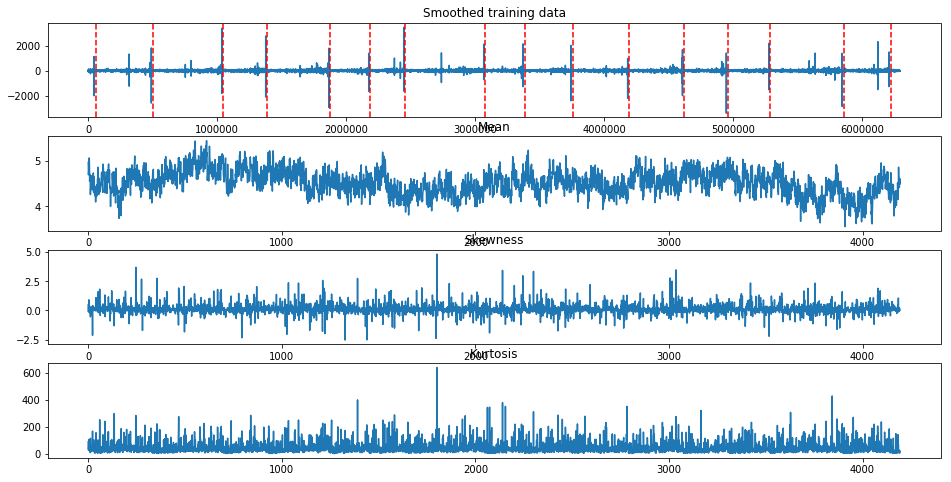

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(411)
plt.title('Smoothed training data')
plt.plot(train_acoustic_data_small)
for ti in tf:
    plt.axvline(x = ti/100, color = 'r', linestyle = '--')

plt.subplot(412)
plt.title('Mean')
plt.plot(X_train['meanA'])

plt.subplot(413)
plt.title('Skewness')
plt.plot(X_train['skewA'])

plt.subplot(414)
plt.title('Kurtosis')
plt.plot(X_train['kurtA'])

#### Define same features for test set

In [20]:
X_test = pd.DataFrame(index = range(n_test), columns = 
                    ['meanA', 'varA', 'varAnorm', 'skewA', 'skewAnorm', 'kurtA', 'kurtAnorm',
                     'meanB', 'varB', 'varBnorm', 'skewB', 'skewBnorm', 'kurtB', 'kurtBnorm',
                     'q01A', 'q02A', 'q03A', 'q04A', 'q05A', 'q06A', 'q07A', 'q08A', 'q09A',
                     'q01B', 'q02B', 'q03B', 'q04B', 'q05B', 'q06B', 'q07B', 'q08B', 'q09B',
                     'q91A', 'q92A', 'q93A', 'q94A', 'q95A', 'q96A', 'q97A', 'q98A', 'q99A',
                     'q91B', 'q92B', 'q93B', 'q94B', 'q95B', 'q96B', 'q97B', 'q98B', 'q99B',
                     'f00pA', 'f01pA', 'f02pA', 'f03pA', 'f04pA', 'f00nA', 'f01nA', 'f02nA', 'f03nA', 'f04nA',
                     'f00pB', 'f01pB', 'f02pB', 'f03pB', 'f04pB', 'f00nB', 'f01nB', 'f02nB', 'f03nB', 'f04nB',
                     'minA', 'maxA', 'minB', 'maxB'
                    ])

for i in range(n_test):
    if i % 100 == 0:
        print(i)

    testi = pd.read_csv('../input/test/' + seg_id[i] + '.csv')
    X_test.loc[i, 'meanA'] = testi['acoustic_data'][0:round(records/2)].mean()
    X_test.loc[i, 'meanB'] = testi['acoustic_data'][round(records/2)+1:records].mean()
    X_test.loc[i, 'varA'] = testi['acoustic_data'][0:round(records/2)].var()
    X_test.loc[i, 'varB'] = testi['acoustic_data'][round(records/2)+1:records].var()
    X_test.loc[i, 'skewA'] = scipy.stats.skew(testi['acoustic_data'][0:round(records/2)])
    X_test.loc[i, 'skewB'] = scipy.stats.skew(testi['acoustic_data'][round(records/2)+1:records])
    X_test.loc[i, 'kurtA'] = scipy.stats.kurtosis(testi['acoustic_data'][0:round(records/2)])
    X_test.loc[i, 'kurtB'] = scipy.stats.kurtosis(testi['acoustic_data'][round(records/2)+1:records])
    X_test.loc[i, 'varAnorm'] = X_test.loc[i, 'varA']/(X_test.loc[i, 'varA']+X_test.loc[i, 'varB'])
    X_test.loc[i, 'varBnorm'] = X_test.loc[i, 'varB']/(X_test.loc[i, 'varA']+X_test.loc[i, 'varB'])
    X_test.loc[i, 'skewAnorm'] = X_test.loc[i, 'skewA']/(X_test.loc[i, 'skewA']+X_test.loc[i, 'skewB'])
    X_test.loc[i, 'skewBnorm'] = X_test.loc[i, 'skewB']/(X_test.loc[i, 'skewA']+X_test.loc[i, 'skewB'])
    X_test.loc[i, 'kurtAnorm'] = X_test.loc[i, 'kurtA']/(X_test.loc[i, 'kurtA']+X_test.loc[i, 'kurtB'])
    X_test.loc[i, 'kurtBnorm'] = X_test.loc[i, 'kurtB']/(X_test.loc[i, 'kurtA']+X_test.loc[i, 'kurtB'])

    X_test.loc[i, 'q01A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.01)
    X_test.loc[i, 'q02A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.02)
    X_test.loc[i, 'q03A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.03)
    X_test.loc[i, 'q04A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.04)
    X_test.loc[i, 'q05A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.05)
    X_test.loc[i, 'q06A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.06)
    X_test.loc[i, 'q07A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.07)
    X_test.loc[i, 'q08A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.08)
    X_test.loc[i, 'q09A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.09)
    X_test.loc[i, 'q91A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.91)
    X_test.loc[i, 'q92A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.92)
    X_test.loc[i, 'q93A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.93)
    X_test.loc[i, 'q94A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.94)
    X_test.loc[i, 'q95A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.95)
    X_test.loc[i, 'q96A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.96)
    X_test.loc[i, 'q97A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.97)
    X_test.loc[i, 'q98A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.98)
    X_test.loc[i, 'q99A'] = np.quantile(testi['acoustic_data'][0:round(records/2)], 0.99)
    X_test.loc[i, 'q01B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.01)
    X_test.loc[i, 'q02B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.02)
    X_test.loc[i, 'q03B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.03)
    X_test.loc[i, 'q04B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.04)
    X_test.loc[i, 'q05B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.05)
    X_test.loc[i, 'q06B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.06)
    X_test.loc[i, 'q07B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.07)
    X_test.loc[i, 'q08B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.08)
    X_test.loc[i, 'q09B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.09)
    X_test.loc[i, 'q91B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.91)
    X_test.loc[i, 'q92B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.92)
    X_test.loc[i, 'q93B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.93)
    X_test.loc[i, 'q94B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.94)
    X_test.loc[i, 'q95B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.95)
    X_test.loc[i, 'q96B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.96)
    X_test.loc[i, 'q97B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.97)
    X_test.loc[i, 'q98B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.98)
    X_test.loc[i, 'q99B'] = np.quantile(testi['acoustic_data'][round(records/2)+1:records], 0.99)

    X_test.loc[i, 'f00pA'] = sum(testi['acoustic_data'][0:round(records/2)] >= f0pos[0])/75000
    X_test.loc[i, 'f01pA'] = sum(testi['acoustic_data'][0:round(records/2)] >= f0pos[1])/75000
    X_test.loc[i, 'f02pA'] = sum(testi['acoustic_data'][0:round(records/2)] >= f0pos[2])/75000
    X_test.loc[i, 'f03pA'] = sum(testi['acoustic_data'][0:round(records/2)] >= f0pos[3])/75000
    X_test.loc[i, 'f04pA'] = sum(testi['acoustic_data'][0:round(records/2)] >= f0pos[4])/75000
    X_test.loc[i, 'f00nA'] = sum(testi['acoustic_data'][0:round(records/2)] <= f0neg[0])/75000
    X_test.loc[i, 'f01nA'] = sum(testi['acoustic_data'][0:round(records/2)] <= f0neg[1])/75000
    X_test.loc[i, 'f02nA'] = sum(testi['acoustic_data'][0:round(records/2)] <= f0neg[2])/75000
    X_test.loc[i, 'f03nA'] = sum(testi['acoustic_data'][0:round(records/2)] <= f0neg[3])/75000
    X_test.loc[i, 'f04nA'] = sum(testi['acoustic_data'][0:round(records/2)] <= f0neg[4])/75000
    X_test.loc[i, 'f00pB'] = sum(testi['acoustic_data'][round(records/2)+1:records] >= f0pos[0])/74999
    X_test.loc[i, 'f01pB'] = sum(testi['acoustic_data'][round(records/2)+1:records] >= f0pos[1])/74999
    X_test.loc[i, 'f02pB'] = sum(testi['acoustic_data'][round(records/2)+1:records] >= f0pos[2])/74999
    X_test.loc[i, 'f03pB'] = sum(testi['acoustic_data'][round(records/2)+1:records] >= f0pos[3])/74999
    X_test.loc[i, 'f04pB'] = sum(testi['acoustic_data'][round(records/2)+1:records] >= f0pos[4])/74999
    X_test.loc[i, 'f00nB'] = sum(testi['acoustic_data'][round(records/2)+1:records] <= f0neg[0])/74999
    X_test.loc[i, 'f01nB'] = sum(testi['acoustic_data'][round(records/2)+1:records] <= f0neg[1])/74999
    X_test.loc[i, 'f02nB'] = sum(testi['acoustic_data'][round(records/2)+1:records] <= f0neg[2])/74999
    X_test.loc[i, 'f03nB'] = sum(testi['acoustic_data'][round(records/2)+1:records] <= f0neg[3])/74999
    X_test.loc[i, 'f04nB'] = sum(testi['acoustic_data'][round(records/2)+1:records] <= f0neg[4])/74999
    
    X_test.loc[i, 'minA'] = min(testi['acoustic_data'][0:round(records/2)])
    X_test.loc[i, 'maxA'] = max(testi['acoustic_data'][0:round(records/2)])
    X_test.loc[i, 'minB'] = min(testi['acoustic_data'][round(records/2)+1:records])
    X_test.loc[i, 'maxB'] = max(testi['acoustic_data'][round(records/2)+1:records])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [21]:
X_test.head()

,meanA,varA,varAnorm,skewA,skewAnorm,kurtA,kurtAnorm,meanB,varB,varBnorm,skewB,skewBnorm,kurtB,kurtBnorm,q01A,q02A,q03A,q04A,q05A,q06A,q07A,q08A,q09A,q01B,q02B,q03B,q04B,q05B,q06B,q07B,q08B,q09B,q91A,q92A,q93A,q94A,q95A,q96A,q97A,q98A,q99A,q91B,q92B,q93B,q94B,q95B,q96B,q97B,q98B,q99B,f00pA,f01pA,f02pA,f03pA,f04pA,f00nA,f01nA,f02nA,f03nA,f04nA,f00pB,f01pB,f02pB,f03pB,f04pB,f00nB,f01nB,f02nB,f03nB,f04nB,minA,maxA,minB,maxB
0,4.49453333333333,26.6020048089446,0.555400433865711,0.597806758544527,1.09728528651335,41.8403700108912,0.847100045607944,4.48903318710916,21.2949775966843,0.444599566134289,-0.05300153250885,-0.0972852865133477,7.55210756932583,0.152899954392056,-9,-5,-3,-3,-2,-2,-1,-1,0,-8,-5,-4,-3,-2,-2,-1,-1,0,9,10,10,10,11,12,12,14,18,10,10,10,11,11,12,13,14,17.0200000000041,0.86528,0.86528,0.86528,0.86528,0.86528,0.0890933333333333,0.0890933333333333,0.0890933333333333,0.0890933333333333,0.0890933333333333,0.864171522286964,0.864171522286964,0.864171522286964,0.864171522286964,0.864171522286964,0.0898678649048654,0.0898678649048654,0.0898678649048654,0.0898678649048654,0.0898678649048654,-75,115,-37,43
1,4.0804,46.1110306537386,0.657374555731924,0.24314702174024,0.351919976425032,56.5274072237175,0.651675289612769,4.26195015933546,24.0331972475046,0.342625444268076,0.447768635308392,0.648080023574968,30.2142693822906,0.348324710387231,-15,-8,-5,-4,-3,-2,-2,-1,-1,-9,-5,-4,-3,-2,-1,-1,-1,0,9,10,10,11,11,12,14,16,23,9,9,10,10,10,11,12,13,17,0.833533333333333,0.833533333333333,0.833533333333333,0.833533333333333,0.833533333333333,0.114453333333333,0.114453333333333,0.114453333333333,0.114453333333333,0.114453333333333,0.863664848864652,0.863664848864652,0.863664848864652,0.863664848864652,0.863664848864652,0.0888411845491273,0.0888411845491273,0.0888411845491273,0.0888411845491273,0.0888411845491273,-140,152,-60,103
2,4.61986666666667,69.7786423641229,0.722929898891413,0.570826541971819,2.43430311990297,149.58810932812,0.816675518101291,4.60060800810678,26.7433613199493,0.277070101108587,-0.336333747173704,-1.43430311990297,33.5790188795446,0.183324481898709,-13,-7,-4,-3,-2,-2,-1,-1,0,-9,-5,-3,-2,-1,-1,-1,0,0,10,10,10,11,11,12,13,16,22,9,10,10,10,11,11,12,14,18,0.873826666666667,0.873826666666667,0.873826666666667,0.873826666666667,0.873826666666667,0.0857333333333333,0.0857333333333333,0.0857333333333333,0.0857333333333333,0.0857333333333333,0.884411792157229,0.884411792157229,0.884411792157229,0.884411792157229,0.884411792157229,0.0754543393911919,0.0754543393911919,0.0754543393911919,0.0754543393911919,0.0754543393911919,-193,248,-78,92
3,4.58749333333333,22.3679764896405,0.660870357491887,0.0347965567727554,0.303352263486943,41.8397336877224,0.686332101233356,4.47551300684009,11.4782631488427,0.339129642508113,0.0799102081373839,0.696647736513057,19.1216195879518,0.313667898766644,-8,-4,-2,-1,-1,-1,0,0,0,-3,-2,-1,-1,0,0,0,0,1,9,9,9,10,10,11,11,13,16,8,9,9,9,9,10,10,11,12,0.899946666666667,0.899946666666667,0.899946666666667,0.899946666666667,0.899946666666667,0.0618533333333333,0.0618533333333333,0.0618533333333333,0.0618533333333333,0.0618533333333333,0.911345484606461,0.911345484606461,0.911345484606461,0.911345484606461,0.911345484606461,0.0487873171642289,0.0487873171642289,0.0487873171642289,0.0487873171642289,0.0487873171642289,-93,85,-54,72
4,4.23237333333333,24.2540593547384,0.360958604609518,0.403942752799022,1.13624564250387,44.2871564035163,0.347883585095184,4.02434699129322,42.9394056160613,0.639041395390482,-0.0484362164580965,-0.136245642503875,83.0173739076767,0.652116414904816,-8,-5,-3,-2,-2,-1,-1,-1,0,-12,-7,-5,-4,-3,-2,-2,-1,-1,9,9,9,10,10,11,12,13,17,9,9,10,10,11,12,13,16,21,0.867106666666667,0.867106666666667,0.867106666666667,0.867106666666667,0.867106666666667,0.0851066666666667,0.0851066666666667,0.0851066666666667,0.0851066666666667,0.0851066666666667,0.841611221482953,0.841611221482953,0.841611221482953,0.841611221482953,0.841611221482953,0.108068107574768,0.108068107574768,0.108068107574768,0.

### 3. Modelling

As in the 2017 paper, we will use Random Forest (see parameterization in I.2.a).

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor

In [23]:
Xsub_train, Xsub_val, ysub_train, ysub_val = train_test_split(X_train, y_train, test_size=0.4)

model_RF = RandomForestRegressor(n_estimators = 1000,
                                 criterion = 'mse',
                                 max_features = 0.4)

model_RF.fit(Xsub_train, ysub_train)
model_RF_pred_valset = model_RF.predict(Xsub_val)
MAE = mean_absolute_error(ysub_val, model_RF_pred_valset)
MAE

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


2.1587246471340356

Since Boosting often outperforms Random Forests, I also try CatBoost to slightly improve my score.

In [24]:
### try CatBoost?
#Xsub_train, Xsub_val, ysub_train, ysub_val = train_test_split(X_train, y_train, test_size=0.4)

model_CatBoost = CatBoostRegressor(silent=True)

model_CatBoost.fit(Xsub_train, ysub_train)
model_CatBoost_pred_valset = model_CatBoost.predict(Xsub_val)
MAE = mean_absolute_error(ysub_val, model_CatBoost_pred_valset)
MAE

2.1161418609595346

### 4. Submission

#### Random Forest

In [25]:
#rerun model on full training set and predict on test set
model_RF = RandomForestRegressor(n_estimators = 1000,
                                 criterion = 'mse',
                                 max_features = 0.4)

model_RF.fit(X_train, y_train)
model_RF_pred_testset = model_RF.predict(X_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [26]:
submission['time_to_failure'] = model_RF_pred_testset
submission.to_csv('submission_RF.csv', index = False)
submission.head()

,seg_id,time_to_failure
0,seg_00030f,4.388741321116686
1,seg_0012b5,4.655447030499578
2,seg_00184e,5.648235265269876
3,seg_003339,8.026273129490514
4,seg_0042cc,5.820816169440747


In [27]:
model_CatBoost = CatBoostRegressor(silent=True)

model_CatBoost.fit(X_train, y_train)
model_CatBoost_pred_testset = model_CatBoost.predict(X_test)

In [28]:
submission['time_to_failure'] = model_CatBoost_pred_testset
submission.to_csv('submission_CatBoost.csv', index = False)
submission.head()

,seg_id,time_to_failure
0,seg_00030f,3.111329060122305
1,seg_0012b5,6.166937645972351
2,seg_00184e,6.150599885541819
3,seg_003339,8.393607971478449
4,seg_0042cc,6.291018050510441
